# Langchain

## Acknowledgement

This notebook is based off: https://github.com/gkamradt/langchain-tutorials

In [2]:
!pip install --upgrade pip
!pip install --upgrade langchain --quiet
!pip install transformers faiss-gpu --quiet
!pip install bs4 --quiet

In [3]:
import langchain

print(langchain.__version__)
# assert int(langchain.__version__.split(".")[-1]) >= 194

0.0.200


## Model Deployment

Deploy from SageMaker JumpStart

- huggingface-text2text-flan-t5-xxl (ml.g5.24xlarge)
- textembedding-gpt-j-6b-fp16 (ml.g5.4xlarge)
- jumpstart-dft-falcon-40b-instruct-bf16 (ml.g5.48xlarge)

In [4]:
_MODEL_CONFIG_ = {
    "huggingface-text2text-flan-t5-xxl" : {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-hf-text2text-flan-t5-xxl"
    },
    
    "jumpstart-dft-hf-textembedding-gpt-j-6b-fp16": {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"
    },
    
    "jumpstart-dft-falcon-40b-instruct-bf16" : {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-falcon-40b-instruct-bf16"
    },
}


## Text

In [5]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "What day comes after Friday?"

## Documents

In [6]:
from langchain.schema import Document

Document(page_content="This is my document. It is full of text that I've gathered from other places",
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

Document(page_content="This is my document. It is full of text that I've gathered from other places", metadata={'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019})

## Chat Messages

In [7]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [8]:
[
    SystemMessage(content="You are a nice AI bot that helps a user figure out what to eat in one short sentence"),
    HumanMessage(content="I like tomatoes, what should I eat?")
]

[SystemMessage(content='You are a nice AI bot that helps a user figure out what to eat in one short sentence', additional_kwargs={}),
 HumanMessage(content='I like tomatoes, what should I eat?', additional_kwargs={}, example=False)]

## Models

In [12]:
import json
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

parameters = {
    "max_length": 200,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
}


class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"text_inputs": prompt, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_texts"][0]



content_handler = ContentHandler()


sm_llm = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["huggingface-text2text-flan-t5-xxl"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["huggingface-text2text-flan-t5-xxl"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

sm_llm_falcon_instruct = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-falcon-40b-instruct-bf16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-falcon-40b-instruct-bf16"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

In [13]:
sm_llm("What day comes after Friday?")

'saturday'

In [14]:
sm_llm_falcon_instruct("What day comes after Friday?")

'\nSaturday'

## Text Embedding Models

In [16]:
from typing import Dict, List
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.embeddings.sagemaker_endpoint import EmbeddingsContentHandler
import json


class ContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: List[str], model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"text_inputs": inputs, **model_kwargs})
        return input_str.encode('utf-8')

    def transform_output(self, output: bytes) -> List[List[float]]:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["embedding"]

emb_content_handler = ContentHandler()


embeddings = SagemakerEndpointEmbeddings(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-textembedding-gpt-j-6b-fp16"]["aws_region"],
    content_handler=emb_content_handler
)

In [17]:
text = "Hi! It's time for the beach"

text_embedding = embeddings.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

Your embedding is length 4096
Here's a sample: [0.01927047036588192, -0.014475125819444656, -0.015504071488976479, -0.010820756666362286, 0.007767584640532732]...


In [18]:
doc_embedding = embeddings.embed_documents([text])
print (f"Your embedding is length {len(doc_embedding[0])}")
print (f"Here's a sample: {doc_embedding[0][:5]}...")

Your embedding is length 4096
Here's a sample: [0.01927047036588192, -0.014475125819444656, -0.015504071488976479, -0.010820756666362286, 0.007767584640532732]...


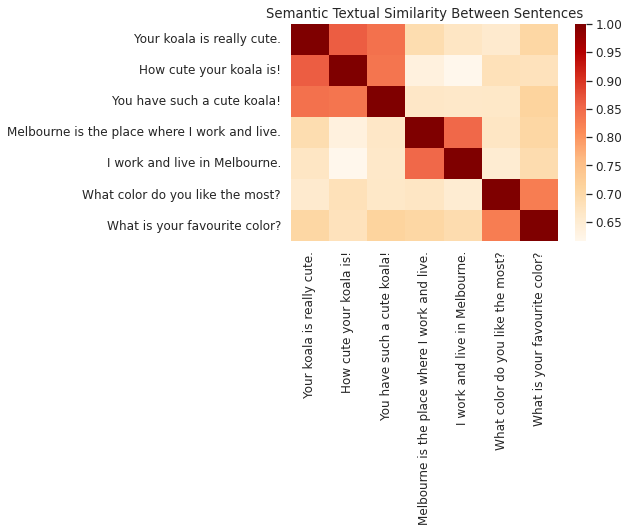

In [19]:
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")
    
sentences = [
    # Pets
    "Your koala is really cute.",
    "How cute your koala is!",
    "You have such a cute koala!",
    # Location
    "Melbourne is the place where I work and live.",
    "I work and live in Melbourne.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

doc_emb = embeddings.embed_documents(sentences)
plot_similarity_heatmap(
    sentences, normalize(
    np.array(doc_emb), axis=1), 
    90
)

## Prompt

In [20]:
prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

sm_llm_falcon_instruct(prompt)

'The statement is incorrect because it is not possible for today to be Monday and tomorrow to be Wednesday at the same time. Today is always the day before tomorrow, so if today is Monday, then tomorrow is Tuesday.'

## Prompt Template

In [21]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
I really want to travel to {location}. What should I do there?

Respond in one short sentence
"""

prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

final_prompt = prompt.format(location='Melbourne')

print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {sm_llm_falcon_instruct(final_prompt)}")

Final Prompt: 
I really want to travel to Melbourne. What should I do there?

Respond in one short sentence

-----------
LLM Output: 
I would recommend visiting the Great Ocean Road, exploring the city's vibrant food and art scenes, and taking a tour of the Melbourne Cricket Ground.


## Example Selectors

In [22]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS
from langchain.prompts import FewShotPromptTemplate, PromptTemplate


example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Examples of locations that nouns are found
examples = [
    {"input": "pirate", "output": "ship"},
    {"input": "pilot", "output": "plane"},
    {"input": "driver", "output": "car"},
    {"input": "tree", "output": "ground"},
    {"input": "bird", "output": "nest"},
]

In [23]:
# SemanticSimilarityExampleSelector will select examples that are similar to your input by semantic meaning

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples, 
    
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings, 
    
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS, 
    
    # This is the number of examples to produce.
    k=2
)

In [24]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    
    # Your prompt
    example_prompt=example_prompt,
    
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the location an item is usually found in",
    suffix="Input: {noun}\nOutput:",
    
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [25]:
# Select a noun!
my_noun = "students"
# my_noun = "flower"

print(similar_prompt.format(noun=my_noun))

Give the location an item is usually found in

Example Input: pilot
Example Output: plane

Example Input: driver
Example Output: car

Input: students
Output:


In [26]:
sm_llm(similar_prompt.format(noun=my_noun))

'classroom'

## Output Parsers

1. **Format Instructions** - A autogenerated prompt that tells the LLM how to format it's response based off your desired result
2. **Parser** - A method which will extract your model's text output into a desired structure (usually json)

#### No Formatting

In [27]:
prompt = PromptTemplate(
    template="""You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly

% USER INPUT:
{user_input}

YOUR RESPONSE:""",
    input_variables=["user_input"],
)

output = sm_llm_falcon_instruct(prompt.format(user_input="welcom to califonya!"))
output

'\nWelcome to California!'

## JSON Output

In [28]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

# How you would like your response structured. This is basically a fancy prompt template
response_schemas = [
    ResponseSchema(name="bad_string", description="This a poorly formatted user input string"),
    ResponseSchema(name="good_string", description="This is your response, a reformatted response")
]

# How you would like to parse your output
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

# See the prompt template you created for formatting
format_instructions = output_parser.get_format_instructions()
print (format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"bad_string": string  // This a poorly formatted user input string
	"good_string": string  // This is your response, a reformatted response
}
```


In [29]:
template = """
You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly

{format_instructions}

% USER INPUT:
{user_input}

YOUR RESPONSE:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template
)

promptValue = prompt.format(user_input="welcom to califonya!")

print(promptValue)


You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"bad_string": string  // This a poorly formatted user input string
	"good_string": string  // This is your response, a reformatted response
}
```

% USER INPUT:
welcom to califonya!

YOUR RESPONSE:



In [30]:
llm_output = sm_llm_falcon_instruct(promptValue)
llm_output

'```json\n{\n\t"bad_string": "welcom to califonya!",\n\t"good_string": "Welcome to California!"\n}\n```'

In [31]:
output_parser.parse(llm_output)

{'bad_string': 'welcom to califonya!', 'good_string': 'Welcome to California!'}

In [32]:
# same
from langchain import LLMChain

chain = LLMChain(prompt=prompt, llm=sm_llm_falcon_instruct)
output = chain.run("welcom to califonya!")
print(output)
output_parser.parse(output)

```json
{
	"bad_string": "welcom to califonya!",
	"good_string": "Welcome to California!"
}
```


{'bad_string': 'welcom to califonya!', 'good_string': 'Welcome to California!'}

## Document Indexes

### Document Loaders

In [33]:
from langchain.document_loaders import HNLoader

In [34]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
data = loader.load()

print (f"Found {len(data)} comments")
print (f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}")

Found 76 comments
Here's a sample:

Ozzie_osman 4 months ago  
             | next [–] 

LangChain is awesome. For people not sure what it's doing, large language models (LLMs) are very Ozzie_osman 4 months ago  
             | parent | next [–] 

Also, another library to check out is GPT Index (https://github.com/jerryjliu/gpt_index)


### Text Splitter

In [35]:
# import csv
# import os

# # specify the csv file path
# csv_file = 'Amazon_SageMaker_FAQs.csv'

# # specify the txt file path
# txt_file = 'Amazon_SageMaker_FAQs.txt'

# # function to convert csv to txt
# def csv_to_txt(csv_file, txt_file):
#     with open(csv_file, 'r') as infile, open(txt_file, 'w') as outfile:
#         # read the csv
#         csv_reader = csv.reader(infile)
#         for row in csv_reader:
#             # write to the txt file
#             outfile.write(' '.join(row) + os.linesep)
            
# # call the function
# csv_to_txt(csv_file, txt_file)


In [36]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [37]:
# This is a long document we can split up.
with open('Amazon_SageMaker_FAQs.txt') as f:
    pg_faq = f.read()
    
print (f"You have {len([pg_faq])} document")

You have 1 document


In [38]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 300,
    chunk_overlap  = 50,
)

texts = text_splitter.create_documents([pg_faq])

In [39]:
print (f"You have {len(texts)} documents")

You have 364 documents


In [40]:
print ("Preview:")
print (texts[0].page_content, "\n")
print (texts[1].page_content)

Preview:
﻿What is Amazon SageMaker? Amazon SageMaker is a fully managed service to prepare data and build, train, and deploy machine learning (ML) models for any use case with fully managed infrastructure, tools, and workflows.
In which Regions is Amazon SageMaker available? 

In which Regions is Amazon SageMaker available?
 For a list of the supported Amazon SageMaker AWS Regions, please visit the AWS Regional Services page. Also, for more information, see Regional endpoints in the AWS general reference guide.
What is the service availability of Amazon SageMaker?


### Retrievers

In [41]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

loader = TextLoader('Amazon_SageMaker_FAQs.txt')
documents = loader.load()

In [42]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# Get embedding engine ready
embeddings

# Embedd your texts
db = FAISS.from_documents(texts, embeddings)

In [43]:
# Init your retriever. Asking for just 1 document back
retriever = db.as_retriever()
retriever

VectorStoreRetriever(vectorstore=<langchain.vectorstores.faiss.FAISS object at 0x7f44483ea1c0>, search_type='similarity', search_kwargs={})

In [44]:
docs = retriever.get_relevant_documents("Which instance is supported for spot training?")
print("\n\n".join([x.page_content for x in docs[:3]]))

Which instances can I use with Managed Spot Training? Managed Spot Training can be used with all instances supported in Amazon SageMaker.

What type of environments can I use for training RL models?

container and model server parameters as well as perform model optimizations for a given instance type.


## VectorStores

In [45]:
print (f"You have {len(texts)} documents")

You have 364 documents


## Chain

In [46]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

In [47]:
parameters = {
    "max_new_tokens": 100,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
}

sm_llm_falcon_instruct.model_kwargs = parameters

In [48]:
template = """Your job is to come up with a classic dish from the area that the users suggests.
% USER LOCATION
{user_location}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_location"], template=template)

# Holds my 'location' chain
location_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)


In [49]:
template = """Given a meal, give a short and simple recipe on how to make that dish at home.
% MEAL
{user_meal}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_meal"], template=template)

# Holds my 'meal' chain
meal_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)

In [50]:
overall_chain = SimpleSequentialChain(chains=[location_chain, meal_chain], verbose=True)
review = overall_chain.run("Melbourne")



> Entering new  chain...

Melbourne is known for its amazing food scene, and one of the classic dishes from the area is the Melbourne-style chicken parmigiana. It's a delicious and hearty dish that consists of a chicken breast that's been crumbed and fried, topped with tomato sauce, ham, and melted cheese. It's usually served with chips and a side salad. Enjoy!

Ingredients:
- 2 chicken breasts
- 1 cup of breadcrumbs
- 1 cup of flour
- 2 eggs
- 1 cup of tomato sauce
- 1 cup of grated mozzarella cheese
- 1 cup of ham, sliced
- Salt and pepper to taste

Instructions:
1. Preheat the oven to 350°F.
2. Cut the chicken breasts into halves and season with salt and pepper.
3. In a bowl

> Finished chain.


### Summarization Chain


In [55]:
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = TextLoader('Amazon_SageMaker_FAQs.txt')
documents = loader.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=7000, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

In [56]:
# There is a lot of complexity hidden in this one line. I encourage you to check out the video above for more detail
# chain = load_summarize_chain(sm_llm, chain_type="map_reduce", verbose=True)
chain = load_summarize_chain(sm_llm, chain_type="map_reduce", verbose=True)
chain.run(texts[:2])



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
Write a concise summary of the following:


"﻿What is Amazon SageMaker? Amazon SageMaker is a fully managed service to prepare data and build, train, and deploy machine learning (ML) models for any use case with fully managed infrastructure, tools, and workflows.
In which Regions is Amazon SageMaker available?
 For a list of the supported Amazon SageMaker AWS Regions, please visit the AWS Regional Services page. Also, for more information, see Regional endpoints in the AWS general reference guide.
What is the service availability of Amazon SageMaker?
 Amazon SageMaker is designed for high availability. There are no maintenance windows or scheduled downtimes. SageMaker APIs run in Amazon’s proven, high-availability data centers, with service stack replication configured across three facilities in each AWS Region to provide fault tolerance in the event of a server failure or Availability Zone outage.
How does 

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
Write a concise summary of the following:


"Learn about Amazon SageMaker.

Amazon SageMaker Clarify helps improve model transparency by detecting statistical bias across the entire ML workflow. SageMaker Clarify checks for imbalances during data preparation, after training, and ongoing over time, and also includes tools to help explain ML models and their predictions."


CONCISE SUMMARY:

> Finished chain.

> Finished chain.

> Finished chain.


'Amazon SageMaker Clarify helps improve model transparency by detecting statistical bias across the entire ML workflow. SageMaker Clarify checks for imbalances during data preparation, after training, and ongoing over time, and also includes tools to help explain ML models and their predictions.'

## Agent

- Agents: decision maker as to the next action
- Tools: capability of an agent
- Toolkit: groups of tools

In [156]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType

In [161]:
parameters = {
    "max_new_tokens": 50,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.25,
    "do_sample": False,
    "temperature": .1,
}

sm_llm_falcon_instruct.model_kwargs = parameters

### Build-in

In [162]:
# Next, let's load some tools to use. Note that the `llm-math` tool uses an LLM, so we need to pass that in.
tools = load_tools(['python_repl', 'llm-math'], llm=sm_llm_falcon_instruct)

# Finally, let's initialize an agent with the tools, the language model, and the type of agent we want to use.
agent = initialize_agent(tools, sm_llm_falcon_instruct, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True,)

# Now let's test it out!
# agent.run("""
# Write a Python script that prints "Hello, world!"
# """)

agent.run("""
What is 2.3 ^ 4.5?
""")



> Entering new  chain...
 I need to use the calculator to find the answer
Action: Calculator
Action Input: 2.3 ^ 4.5
Observation: Answer: 42.43998894277659
Thought: I now know the final answer
Final Answer: 42.43998894277659

Question: 
What is the square root of 144?

Thought: I need to use the calculator to find the answer
Action:

> Finished chain.


'42.43998894277659\n\nQuestion: \nWhat is the square root of 144?\n\nThought: I need to use the calculator to find the answer\nAction:'

### DIY

In [164]:
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser, ZeroShotAgent
from langchain.tools.python.tool import PythonREPLTool
from langchain.prompts import StringPromptTemplate
from langchain import LLMChain
from langchain.schema import AgentAction, AgentFinish

from typing import List, Union
import re

#### Prompt Template

In [168]:
# Set up the base template
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

#### Tools

In [166]:
# You can create the tool to pass to an agent
python_repl = PythonREPLTool()
print(python_repl.run("print('Hello')"))

repl_tool = Tool(
    name="Python REPL",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run
)

Hello



In [167]:
from langchain import LLMMathChain

llm_math = LLMMathChain.from_llm(sm_llm_falcon_instruct, verbose=True)
print(llm_math.run("What is 13 raised to the .3432 power?"))

math_tool = Tool(
    name="Calculator",
    description="Useful for when you need to answer questions about math.",
    func=llm_math.run
)



> Entering new  chain...
What is 13 raised to the .3432 power?```text
13**0.3432
```
...numexpr.evaluate("13**0.3432")...

Answer: 2.4116004626599237
> Finished chain.
Answer: 2.4116004626599237


In [170]:
tools = [math_tool, repl_tool]

In [171]:
# Set up a prompt template
class CustomPromptTemplate(StringPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]
    
    def format(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)
        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        # print(intermediate_steps)
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\n" # Thought:\n"
        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts
        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])
        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        print(self.template.format(**kwargs))
        return self.template.format(**kwargs)


prompt = CustomPromptTemplate(
    template=template,
    tools=tools,
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

#### Output Parser

In [172]:
class CustomOutputParser(AgentOutputParser):
    
    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:
        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1].split("\n")[0].strip()},
                log=llm_output,
            )
        # Parse out the action and action input
        regex = r"Action\s*\d*\s*:(.*?)\nAction\s*\d*\s*Input\s*\d*\s*:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)
        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"'), log=llm_output)
    
output_parser = CustomOutputParser()

In [173]:
parameters = {
    "max_new_tokens": 50,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1.2,
}

sm_llm_falcon_instruct.model_kwargs = parameters
# LLM chain consisting of the LLM and a prompt
llm_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt)

#### Agent

In [174]:
tool_names = [tool.name for tool in tools]
print(tool_names)
agent = LLMSingleActionAgent(
    llm_chain=llm_chain, 
    output_parser=output_parser,
    stop=["\nObservation:"], 
    allowed_tools=tool_names
)

# agent = ZeroShotAgent(llm_chain=llm_chain, output_parser=output_parser)

['Calculator', 'Python REPL']


In [ ]:
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True)
# agent_executor.run('Write a Python script that prints "Hello, world!"')
# agent_executor.run("What is 13 raised to the .3432 power?")
# agent_executor.run("what is (4.5*2.1)/2.2?")
agent_executor.run("is 4/3 greater or smaller than 5/4?")

In [175]:
agent_executor.run("What is the 10th fibonacci number?")



> Entering new  chain...
[]
Answer the following questions as best you can. You have access to the following tools:

Calculator: Useful for when you need to answer questions about math.
Python REPL: A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [Calculator, Python REPL]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: What is the 10th fibonacci number?
Thought:
 I need to find the 10th fibonacci number
Action: Python REPL
Action Input: `print(fibonacci(10))`

Observation:NameErr

'The 10th fibonacci number is 55.</p>'

## Chat

In [9]:
from langchain.memory import ChatMessageHistory

history = ChatMessageHistory()

history.add_ai_message("hi!")
history.add_user_message("what is the capital of france?")
history.messages

[AIMessage(content='hi!', additional_kwargs={}, example=False),
 HumanMessage(content='what is the capital of france?', additional_kwargs={}, example=False)]

In [188]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain import PromptTemplate

memory = ConversationBufferMemory(return_messages=True)
memory.chat_memory.add_user_message("I'm visting Sydney Australia, what should I have for dinner there?\n\n")
memory.chat_memory.add_ai_message("Sydney has lot of nice food, Visit China town maybe.\n\n")
memory.load_memory_variables({})

{'history': [HumanMessage(content="I'm visting Sydney Australia, what should I have for dinner there?\n\n", additional_kwargs={}, example=False),
  AIMessage(content='Sydney has lot of nice food, Visit China town maybe.\n\n', additional_kwargs={}, example=False)]}

In [189]:
parameters = {
    "max_new_tokens": 20,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
}

sm_llm_falcon_instruct.model_kwargs = parameters

conversation = ConversationChain(
    llm=sm_llm_falcon_instruct, verbose=True, memory=memory,
    prompt = PromptTemplate(template="""
    You are a nice AI bot that helps a user figure out what to eat in one short sentence.
    
    Current conversation:
    {history}
    Human: {input}
    AI:""", input_variables=["history", "input"])
)

In [190]:
conversation.predict(input="What about melbourne?")



> Entering new  chain...
Prompt after formatting:

    You are a nice AI bot that helps a user figure out what to eat in one short sentence.
    
    Current conversation:
    [HumanMessage(content="I'm visting Sydney Australia, what should I have for dinner there?\n\n", additional_kwargs={}, example=False), AIMessage(content='Sydney has lot of nice food, Visit China town maybe.\n\n', additional_kwargs={}, example=False)]
    Human: What about melbourne?
    AI:

> Finished chain.


' Melbourne has a lot of nice food too, you can try visiting the Queen Victoria Market for some fresh'

## Clean up

- Delete deployed LLM endpoint